# Seaborn ile Doğrusal Regresyon

🚀 Seaborn kullanarak Doğrusal Regresyon analizine görsel olarak başlayalım!

Hedefimiz aşağıdakilerin ilk anlayışını elde etmektir:
- `orders` özelikleri ve
- onlarla ilişkili `review_scores`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

⚠️ Devam etmeden önce:
* 💾 Önceki ünitenin Orders challenge'ının çözümünü indirin
* 👥 `order_solution.py` dosyasının içeriğini `olist/order.py` dosyanıza kopyala-yapıştır yapın

⚠️ `olist` deponuzda `order.py` dosyasındaki kod değişikliklerini commit etmeyi unutmayın!

👇 Öncelikle `orders` veri setini içeri aktarın

In [3]:
# Import your orders training set
from olist.order import Order

orders = Order().get_training_data(with_distance_seller_customer=False)

## 1 - Özellik Korelasyonunu İnceleme

❓Özellikler arasındaki çeşitli korelasyonları inceleyin: hangi özellik `review_score` ile en çok korelasyonlu görünüyor?

<details>
    <summary>▸ İpucu</summary>

* `DataFrame.corr(numeric_only=True)` kullanın `sns.heatmap()` ve `cmap='coolwarm'` ile kombinasyon yaparak
* `review_score` ile her bir özellik arasındaki korelasyon katsayılarının mutlak değerlerine bakın,
    * katsayı ne kadar yüksekse, verilen özellik `review_score` ile o kadar çok korelasyonludur (pozitif veya negatif)

</details>

In [4]:
numeric_cols = orders.select_dtypes(include=["number"])
corr_matrix = numeric_cols.corr()
review_corr = (
    corr_matrix["review_score"]
    .sort_values(ascending=False)
)

review_corr


review_score          1.000000
dim_is_five_star      0.791787
price                -0.034742
expected_wait_time   -0.052410
freight_value        -0.090013
number_of_sellers    -0.116942
number_of_items      -0.123492
delay_vs_expected    -0.272281
wait_time            -0.333758
dim_is_one_star      -0.807700
Name: review_score, dtype: float64

* 😏 _Kaptan Açık :_
    * `review_score` kendisiyle %100 korelasyonludur
    * ve `dim_is_one_star` ve `dim_is_five_star` ile güçlü korelasyonludur...
* ⚠️ `review_score` ile ilgili sonraki iki en yüksek korelasyon katsayısı :
    * `wait_time` : - %34
    * `delay_vs_expected` : - %27

## 2. `review_score` ile teslimat süresi arasında Doğrusal Regresyon

👉 Görünüşe göre `review_score` çoğunlukla `wait_time` (= - %34) ve `delay_vs_expected` (- %27) ile korelasyonludur.

🎨 Bu korelasyonları `seaborn` ile araştıralım

### 2.1 Grafikler
❓ Sırasıyla `review_score` ile `wait_time` ve `delay_vs_expected` arasında regresyon yapan 2 grafik oluşturun.

<u>İpuçları</u>:

- Hız açısından veri çerçevesini rastgele bir `10.000 satırlık örneğe` indirin (veri keşiflemede iyi bir uygulama)
- Gerekirse her yürütmede örneği değiştirilmekten kaçınmak için `DataFrame.sample()` sabit bir `random_state` ile kullanın
- Regresyon `lines` çizmek için `sns.regplot()` kullanın
- Saçılım grafiğinin yoğunluğunu daha iyi görselleştirmek için bazı `y_jitter` parametreleri ekleyin
- `sns.regplot()` hemen sonrasına bunu ekleyerek `xlim` ve `ylim` sınırlayın (aynı hücrede):
  ```python
  plt.xlim(right=70)
  plt.ylim(bottom=0)
  ```

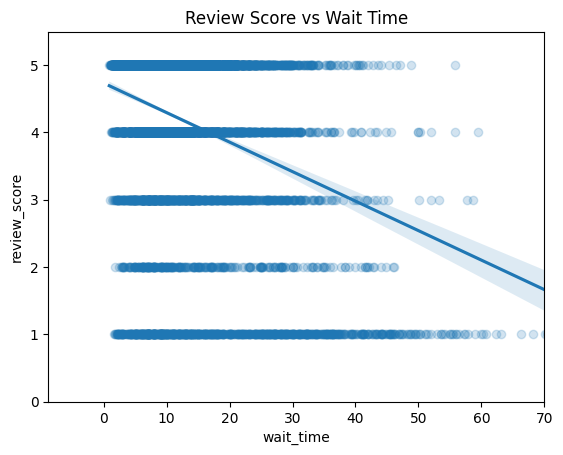

In [5]:
sampled_orders = orders.sample(n=10000, random_state=42)
sns.regplot(
    data=sampled_orders,
    x="wait_time",
    y="review_score",
    scatter_kws={"alpha": 0.2}
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score vs Wait Time")
plt.show()


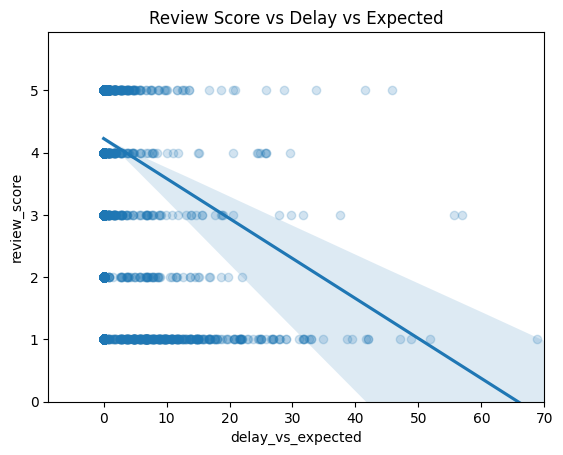

In [6]:
sns.regplot(
    data=sampled_orders,
    x="delay_vs_expected",
    y="review_score",
    scatter_kws={"alpha": 0.2}
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score vs Delay vs Expected")
plt.show()


ℹ️ `regplot` ne yaptı ? 

👉 `review_score` ile `wait_time` ve `delay_vs_exp` arasında `Doğrusal Regresyon` yapmaya çalıştı

🧐 Pek yorumlanabilir görünmüyor, değil mi ?

👉 Haklısınız: sadece 5 farklı review skoru vardır ve bunlar beş farklı olası değeri olan kategorisel bir değişken olarak yorumlanabilir (örneğin: "çok kötü", "kötü", "orta", "iyi" ve "çok iyi") ve `wait_time` ve `delay_vs_exp` olan iki sürekli değere karşı regresyon yapmaya çalışıyoruz.

👀 Ancak regresyon çizgilerine göre çok sezgisel bir desen görebiliriz: bekleme süresi ve/veya gecikme ne kadar uzunsa, review skoru o kadar düşüktür - şaşırtıcı değil. Ama review skoru ne kadar hızlı düşüyor ?

### 2.2 Yorumlama

❓Her eğrinin `eğimini` görsel olarak "hesaplamaya" çalışın. 

✍️ Bu katsayıları veri eğitimi almamış bir kitleye açıklamış olsaydınız, bunları nasıl yorumlayacağınızı yazın.

Her iki grafikte de regresyon çizgisinin negatif eğimli olduğu görülüyor.Bu şu anlama geliyor: teslimat süresi veya beklenenden gecikme arttıkça, ortalama review_score düşüyor.
wait_time arttıkça regresyon çizgisi yaklaşık 5’ten 2–3 bandına doğru iniyor.delay_vs_expected için düşüş daha az dik ama yine istikrarlı biçimde aşağı yönlü.
Sipariş ne kadar geç gelirse, müşteriler o kadar düşük puan veriyor.Gecikme küçükken sorun edilmiyor ama süre uzadıkça memnuniyet belirgin şekilde azalıyor.


<details>
    <summary>Cevap</summary>

- `Slope wait_time ≈ -0.05` : "Bir sipariş teslim edilmesi için beklenen her ek gün için, review skoru ortalama olarak 0.05 azalır"
- `Slope delay ≈ -0.1` : "Bir sipariş _beklenen teslimat tarihinden sonra_ teslim edilmesi için her ek gün, review skoru ortalama olarak 0.1 azalır"

❓ Gecikmenin bekleme süresinden daha etkileyici görünmesine şaşırdınız mı? 

👉 Siparişinizi almak için sabırsız olabilirsiniz ve kısa bir bekleme süresi istersiniz, ancak paketinizi beklenen teslimat tarihinden sonra almaktan daha da hayal kırıklığına uğrarsınız!

</details>

### 2.3 Çıkarımsal Analiz

Bu regplotlar için 100.000 siparişin tamamını kullansak bile, bu siparişler sonuçta sadece 16 ayın verilerini temsil eder...

⚠️⚠️⚠️ Bu katsayıların **istatistiksel olarak anlamlı** olduğundan **ne kadar emin** olduğumuz? ⚠️⚠️⚠️

⚡️ Bu katsayıların istatistiksel anlamlılığı hakkında sorular:

* Bu katsayılar gelecekteki siparişlere iyi bir şekilde genelleştirilebilir mi (diğer her şey eşit olarak) ? (*İdeal cevap: Evet*) 
* Bu katsayıların sınırlı gözlem döneminden kaynaklanan rastgele dalgalanmalar yakalamadığından emin miyiz ? (*İdeal cevap: Hayır*) 

🧐 Bu iki eğim için ortalama değer etrafında **`güven aralığını`** tahmin etmemiz gerekir  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[%95 aralık]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[%95 aralık]} $$

⭐️ Neyse ki, `Seaborn` bu %95 güven aralığını regresyon çizgisinin etrafında gölgeli bir mavi koni ile zaten hesaplamıştır!

❓`Seaborn` `regplot` yeniden kullanarak iki güven aralığını görselleştirin:
- Örnek veri setinizin `boyutunu değiştirin`: 
    - Örnek boyutu küçüldükçe eğimin nasıl değiştiğine dikkat edin. 
    - Güven aralığı hakkında ne dersiniz?
- `ci` adlı regplot parametresi ile oynayarak `güven aralığının boyutunu` değiştirin (%95 varsayılan)

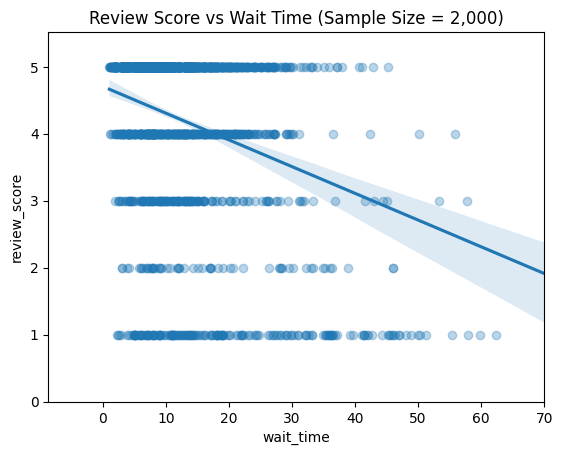

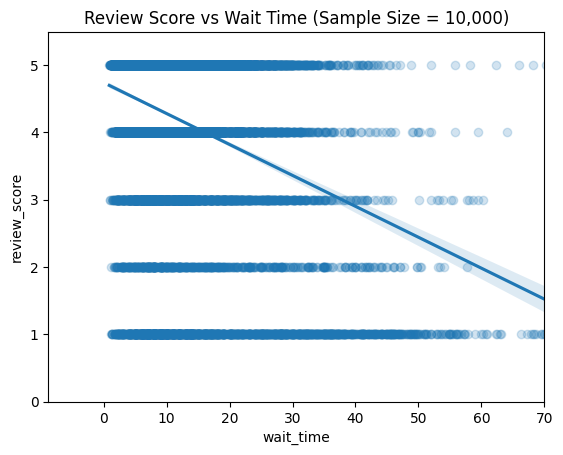

In [11]:
small_sample = orders.sample(n=2000, random_state=42)

sns.regplot(
    data=small_sample,
    x="wait_time",
    y="review_score",
    scatter_kws={"alpha": 0.3},
    ci=95
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score vs Wait Time (Sample Size = 2,000)")
plt.show()
large_sample = orders.sample(n=20000, random_state=42)

sns.regplot(
    data=large_sample,
    x="wait_time",
    y="review_score",
    scatter_kws={"alpha": 0.2},
    ci=95
)

plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Review Score vs Wait Time (Sample Size = 10,000)")
plt.show()



🔎 Yorumlama:

* **Boş Hipotez** $H_0$ : "bu değişken review skoru etkilemez", yani katsayısı sıfıra eşittir

Tüm veri noktalarımızı çizdiğimizde:
- Eğim için %95 güven aralığı 0 değerini içermez.
    - 👉 `Daha yavaş teslimatların daha zayıf yorumlarla ilişkili olduğundan %95 emin`.
- "Teslimat süresinin review skorları üzerindeki etkisi hemen hemen sıfırdır" boş hipotezi ile ilişkili **`p-değeri`** %5'ten düşüktür
    - 👉 Bu boş hipotezi güvenle reddedebilir ve **`alternatif hipotez`** = `"teslimat süresi review skoru üzerinde etkiye sahiptir"` düşünebiliriz

🔥 Bulguşlarımızın **istatistiksel olarak anlamlı** olduğu söylenir. 

⚠️ Ancak, **korelasyon nedensellik anlamına gelmez**. 

- Belirli ürünlerin teslimatı doğal olarak daha yavaş olabilir (örn. ağır ürünler)
    - Bu ürün kategorileri, teslimat sürelerinin ne kadar uzun olursa olsun, genellikle düşük review_score'a sahip olacaktır. 

👉 **Karıştırıcı faktörleri** tanımlamak çok önemlidir ve basit bir tek değişkenli regresyon ile yapılamaz. 

</details>

---
🏁 Tebrikler! 

🙏 Notebook'unuzu `commit` ve `push` etmeyi unutmayın